# Case study: Row-Column Addressed Matrix Probe

## Row-Column Addressed probes

Row-Column Addressed (RCA) probe is a low-cost and portable alternative for fully-populated matrix-array probes in 3D volume reconstruction. 

In 3D ultrasound imaging matrix-array probes are currently the most popular choice. These probes have $n \times n$ elements arranged in a plane along two axis (see images below). It's a natural extension of linear-array probes whose elements are distributed only along a single axis.

One of the problem in handling matrix-array probes is a large number of ultrasound system channels that are needed to control all of the prob'es elements. In the case of matrix array probe this is equal to $n^2$, so it increases squarely with the number of elements along a single axis. For example, the currently popular $32 \times 32$ probes requires an ultrasound system with 1024 channels. Compare it to a linear-array probe, which has 192 elements distributed along axis and requires a system with only 192 channels. 

Various attempts have been made to implement 3D volume reconstruciton using a system with a limited number of components. Te RCA probes are gaining more and more popularity mostly due to large number of elements (and therefore a larger aperture) that can be handled by small number of system channels and ease of implementation of synthetic aperture methods. There are also some challenges and limitations, in particular [Jensen2022]:
- mostly it is possible to image a rectangular area below the probe only,
- the long probe elements needs to be considered on the beamforming stage (cylindrical wave: the emitted field can be considered as plane wave along the first axis and rectangular along the second), 
- some new artifacts like edge waves must be considered in the imaging procedure, which means we may need to implement some additional techniques like roll-off apodization.

In this notebook we present the possiblity of implementing plane wave imaging on RCA probes data. Here we focus on CUDA beamformer implementation details.

This notebook on the work presented in [Flesch2017] and [Jensen2022].

### Coordinate system and units

In this notebook we assume the following coordinate system:
- the origin of the system $(0,0,0)$ is located in the center of the probe, 
- OX axis is along probe's azimuth,
- OY is along probe's elevation,
- OZ - depth (towards direction of imaging).

See the below image for more details.

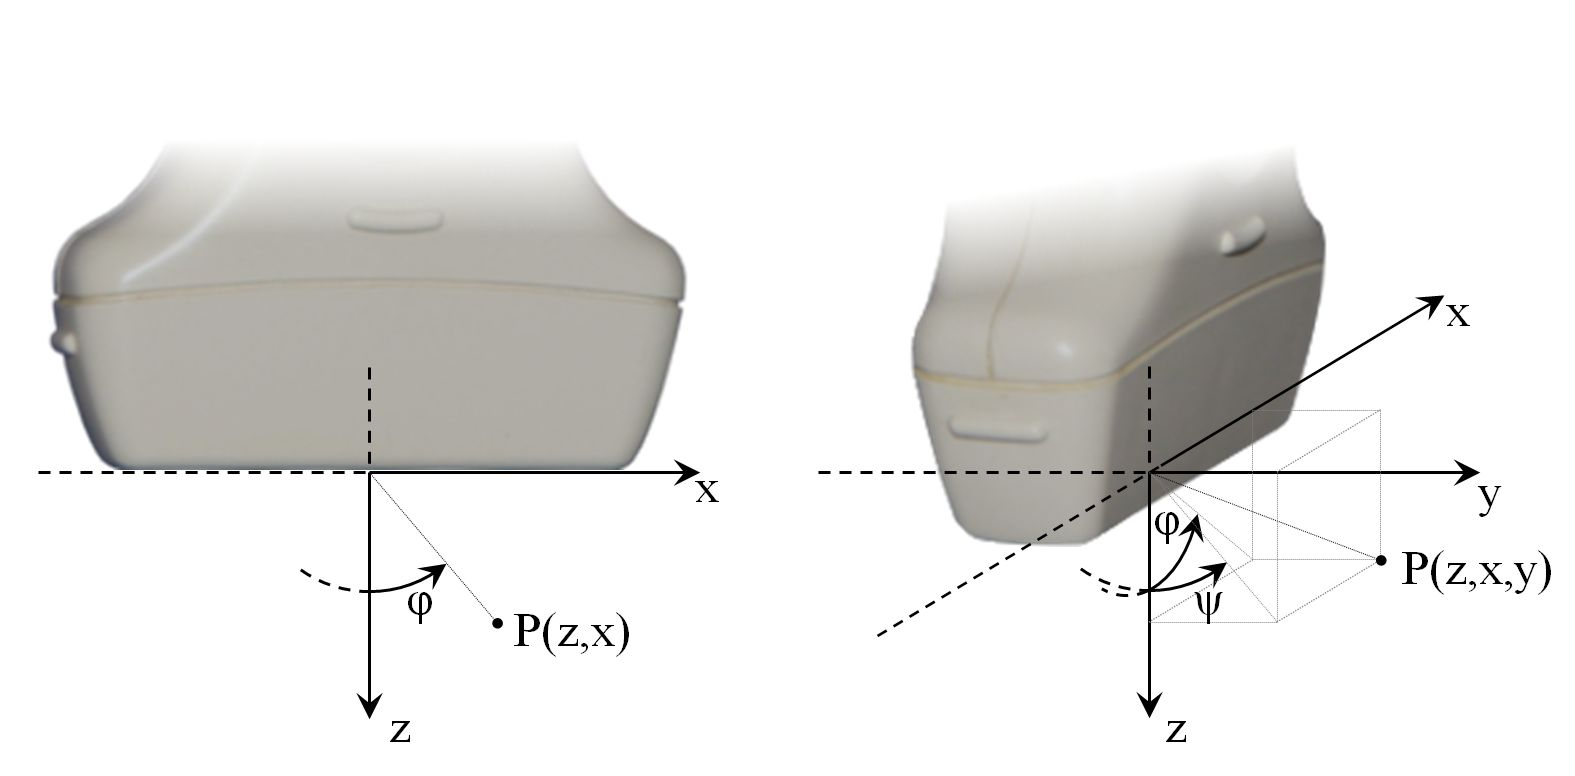

In this notebook, we try to use standard SI units, in particular: distance: meters (m), time: seconds (s), frequency: Hertz (Hz), and so on. In the GPU kernel implementation we avoid using SI unit prefixes like mega-, kilo-, etc. 

### Rows and columns in RCA probes

The figure below shows the idea of the RCA probe construction:
1. _(the image 1st on the left)_: Here we consider a probe with $6 \times 6$ elements. These elements are evenly distributed along both of the axis. If we wanted to control all elements of the probe, we need a system with 36 channels.
2. _(the 2nd and 3rd image)_: Instead of controlling all the elements of the probe, in the case of RCA probe we want to control a group of elements that are spread across along OX or OY axis. In other words, we would like to control 6 long elements along OX axis and 6 long elements along OY axis. This way, in particular, we are able to control the signal beamforming along the OX axis (e.g. on transmission) and and OY axis (e.g. on reception), which gives us some degrees of freedom for 3D volume reconstruction. What is more, we only need $6+6$ channels to control the probe.

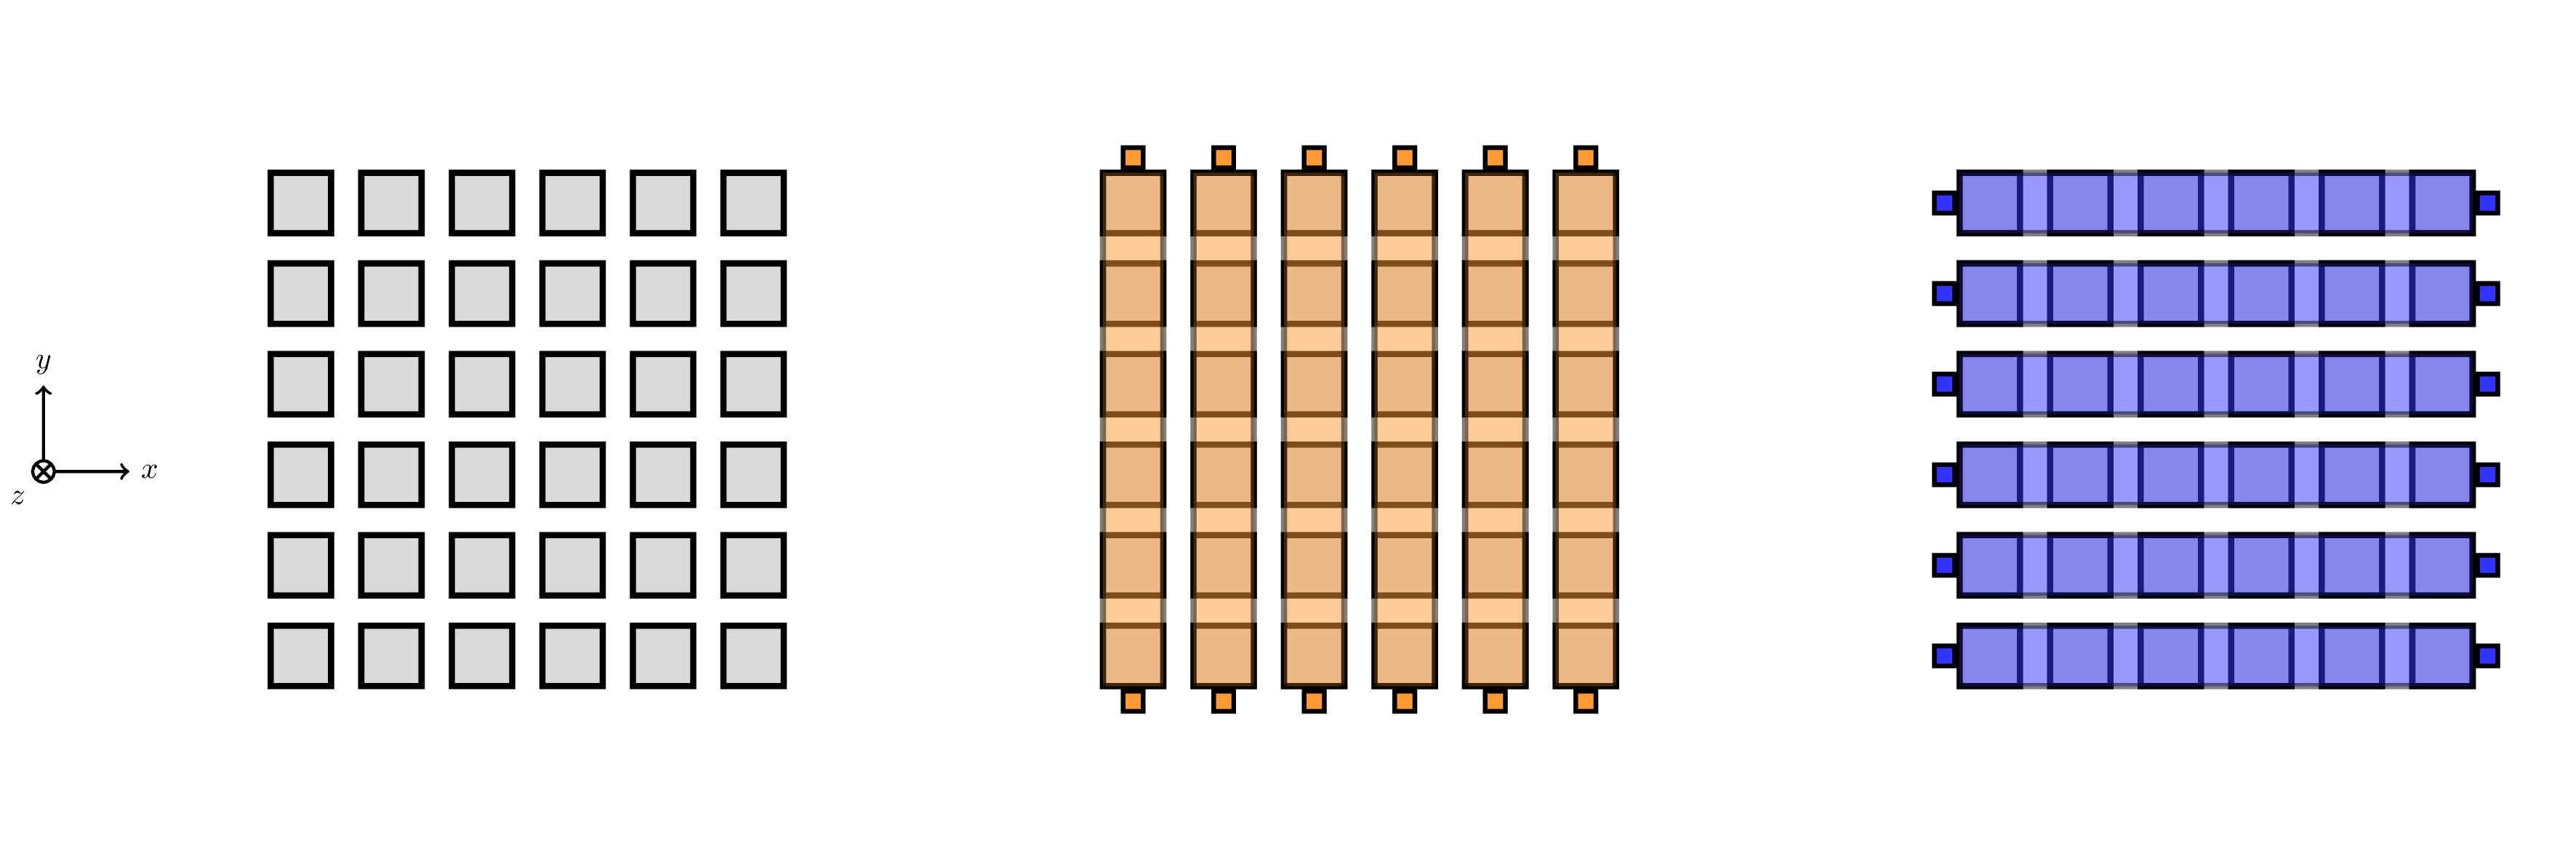

## Plane Wave Imaging with RCA

In the case of imaging with the RCA head, we must be able to control elements distributed along the OX/OY axis and receive the signal with orthogonal elements (OY/OX), otherwise, we will have a situation similar to a linear-array probe (but with the elements are much longer). The image below shows the idea: let's assume, that we transmit signal using elements distributed along OX axis (orange), and receive data using orthogonal elements (OY axis, blue).

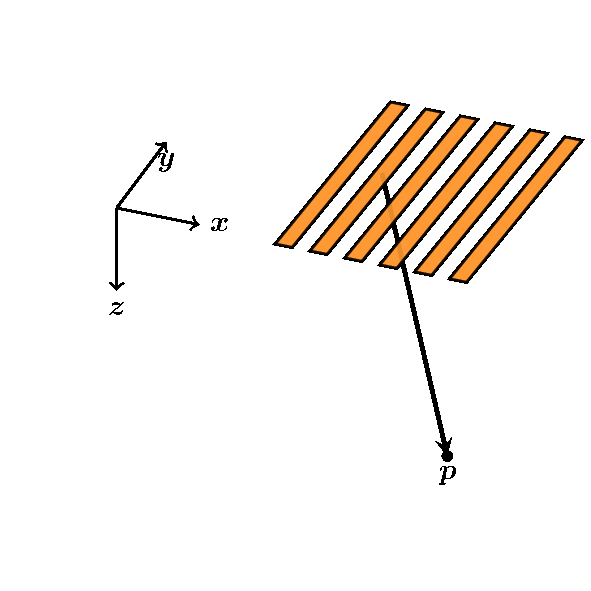

In the case of plane wave transmission the emitted fields should have a rectangular shape, tilted along one of the axis according to the steering angle $\varphi$ (see image below, orange dotted lines). As usually, on the beamforming stage we take a ray-tracing approach, that is, we need first to determine how much time it takes to propage signal from probe to the target point, then back to the receive channels. After determining the transmit and delay, we run the usual delay and sum algorithm in order to the information about the signal in each imaging grid point.

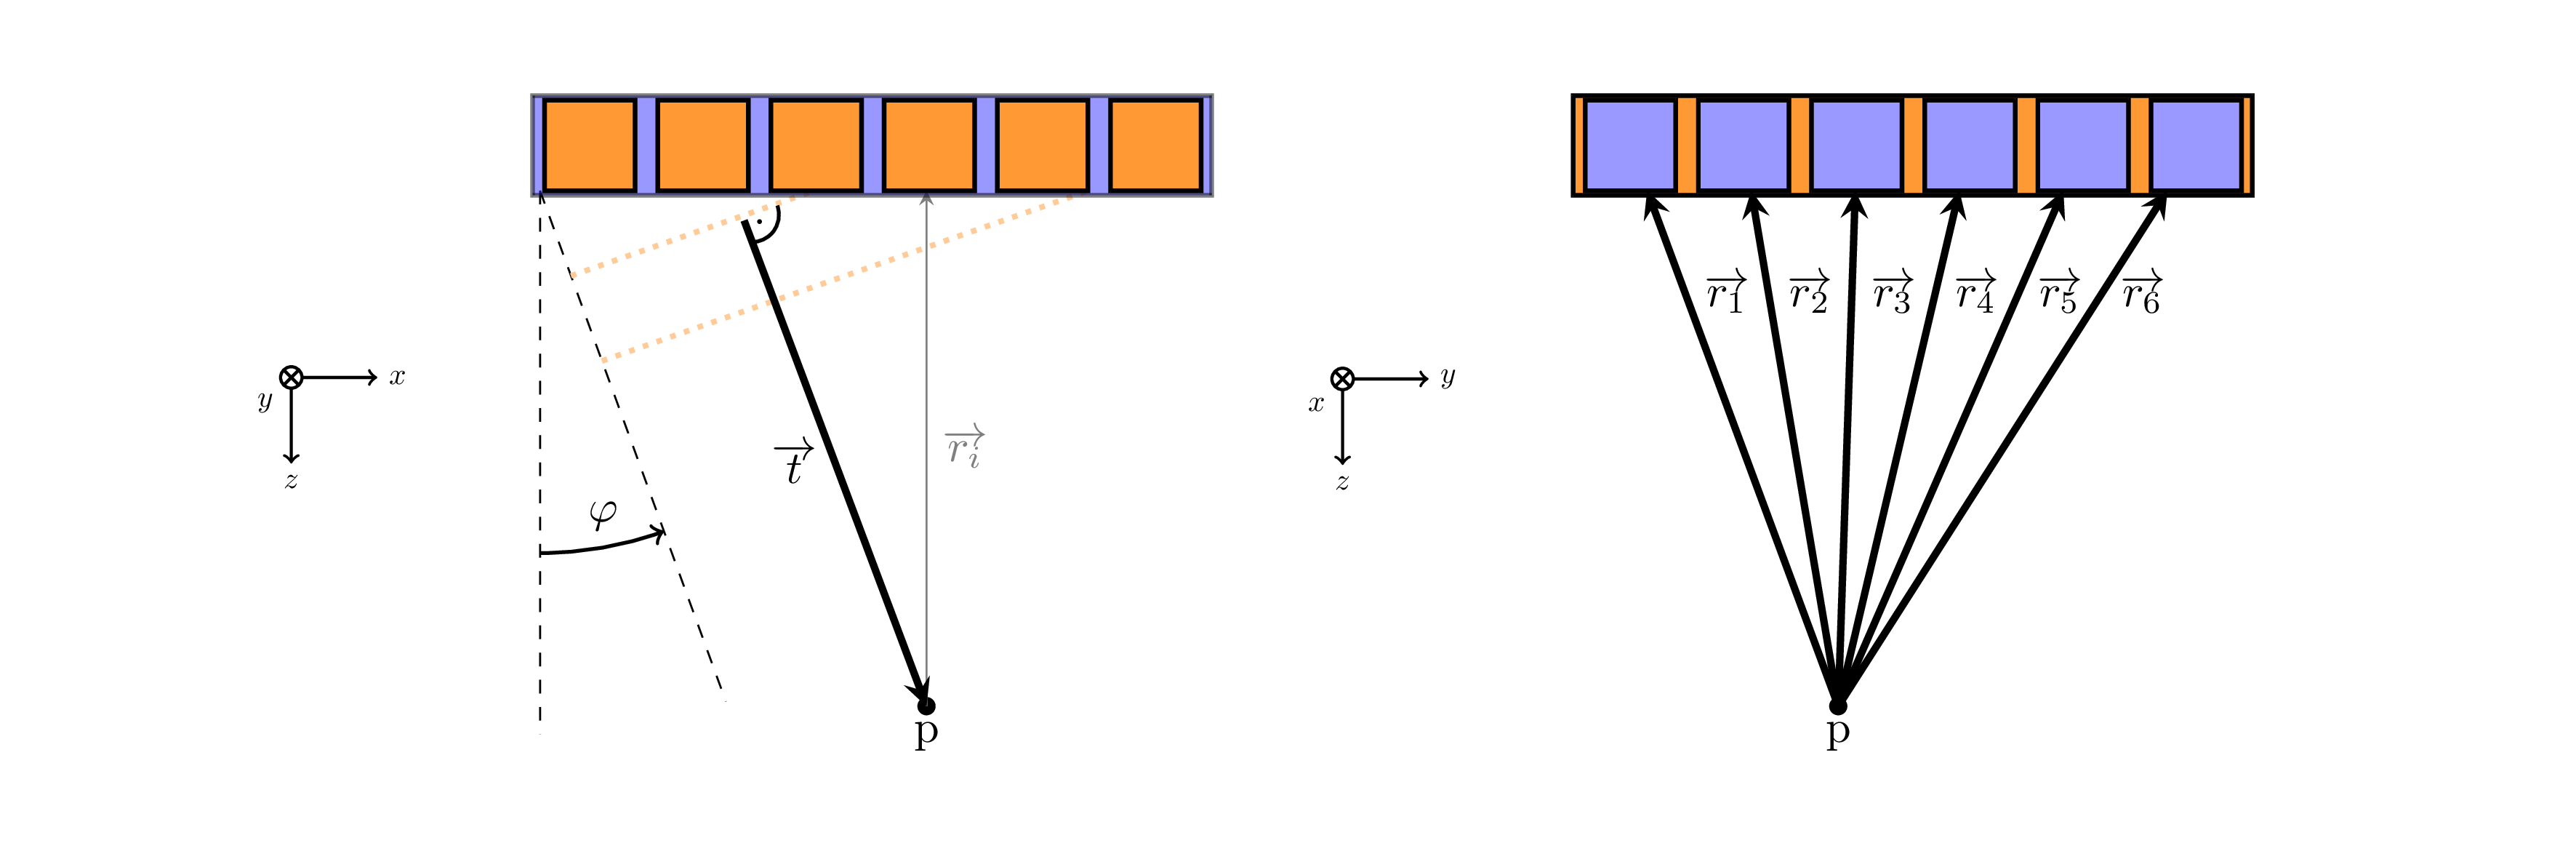

The transmit delay can be computed following in the following way [Flesch2017]:

$\tau(x, y, z, \varphi, r_i) = \frac{\| \overrightarrow{t} \| + \|\overrightarrow{r_i}\|}{c}$

$\|\overrightarrow{t}\| = z\cos(\varphi) + x \sin(\varphi)$

$\|\overrightarrow{r_i}\| = \sqrt{z^2 + (y-r_i)^2}$ 

where:
- $\tau$: receive beamforming delay $(s)$,
- $p = (x, z, y)$ - a target point,
- $\overrightarrow{t}$ - a vector from the transimssion point to the target point $p$,
- $\overrightarrow{r_i}$ - a vector from the target point $p$ to the receive element $r_i$,
- $\varphi$ - steering angle $(rad)$,
- $c$ - speed of sound $(m/s)$. 

Basing on the transmission and receive delays, we can make a couple of observations:
- Using RCA probe we are only able to steer the transmission using angles $(\varphi, \psi=0)$ or $(\varphi=0, \psi)$,
- In the receive beamforming,  $\|\overrightarrow{t}\|$ **does not depend on the** $y$ **value, and** $\|\overrightarrow{r_i}\|$ **does not depend on the** $x$ **value**. That means, in particular, that we need to compute transmit delays only for each $(x, z)$ pair, and use it for all voxels along OY axis. Thus, we are able to reduce calculation along one of the dimensions.

## Volume reconstruction

Let's start implementing the reconstruction algorithm. First, we will import all the necessary Python packages.

Note: 
- The `rca_utils` is a Python module implemented in the `rca_utils.py` file.
- We will use [Panel](https://panel.holoviz.org/) and [vtk](https://pypi.org/project/vtk/) packages for volume 3D visualization.

In [1]:
import numpy as np
import scipy.io
import scipy.signal
import scipy.ndimage
import matplotlib.pyplot as plt
import cupy as cp
import h5py
import pathlib
import panel as pn
pn.extension('vtk')
from rca_utils import (
    view_medium_and_probe_3d,
    view_medium_and_probe_2d,
    view_volume_3d,
    view_volume_2d,
    pretty_print_h5_group,
)


### Data sets

In this notebook we will use synthetic data generated in the [k-wave](http://www.k-wave.org/) simulator. The following environments have been simulated:
- a single point at 20 mm depth,
- a collection of threads at depths from 10 to 40 mm,
- a single cyst at 20 mm depth.

#### Get data

Let's download and load one of the available datasets.

In [2]:
! wget -nc -nv https://www.dropbox.com/s/w9d26v7b332vt92/ball.h5 -P ./data
! wget -nc -nv https://www.dropbox.com/s/dpgct2x4wuce61t/cyst.h5 -P ./data
! wget -nc -nv https://www.dropbox.com/s/yqanmmr5n0yf3yf/multi_wire.h5 -P ./data

In [3]:
f = h5py.File("data/cyst.h5", "r")
f.keys()

<KeysViewHDF5 ['device', 'medium', 'rf_xy', 'rf_yx', 'tx_rx_sequence']>

The file consists of several hdf5 groups (*fields*) containing raw channel data and their metadata, which we describe below. We use `pretty_print_h5_group` function to present all the information available in the file.

#### Medium

In [4]:
medium = f["medium"]
pretty_print_h5_group(medium)

density_array: (108, 108, 216), float64
dx: 0.0003
speed_of_sound: 1540.0000
speed_of_sound_array: (108, 108, 216), float64


The `medium` group describes the medium through which the ultrasonic signal was propagated. In particular, the following fields are available:
- `speed_of_sound`: assumed speed of sound in the medium (m/s),
- `dx`: a distance between two grid points in the density_array and speed_of_sound_array,
- `density_array`: a 3D map of density in the medium,
- `speed_of_sound_array`: a 3D map of speed of sound in the medium.

We use the `dx`, `density_array` and `speed_of_sound` parameters only to visualize the medium through which ultrasound beam was propagated.

#### Device

In [5]:
device = f["device"]
pretty_print_h5_group(device)

n_elements_xy: 64.0000
n_elements_yx: 64.0000
pitch: 0.0003
probe_mask: (108, 108, 216), uint8
sampling_frequency: 21388692.0000


The `device` group describes the device used to transmit and receive an ultrasonic beam, i.e. probe, ultrasound system (both simulated in k-wave). In particular, the following fields are available:
- `n_elements_xy`: number of elements along OX axis,
- `n_elements_yx`: number of elements along OY axis,
- `pitch`: a distance between two probe elements,
- `probe_mask`: a binary mask of the insonified medium, where `1` means there was a transducer at the given location, 0 otherwise,
- `sampling_frequency`: data sampling frequency.

We use the `probe_mask` parameter only to visualize the transducer in the medium through which ultrasound beam was propagated.

Now, having information about the parameters of the device and the medium, we will present the sound velocity distribution in the medium at the time of transmitting the ultrasonic signal. The following code uses the tools from the `rca_utils`. 

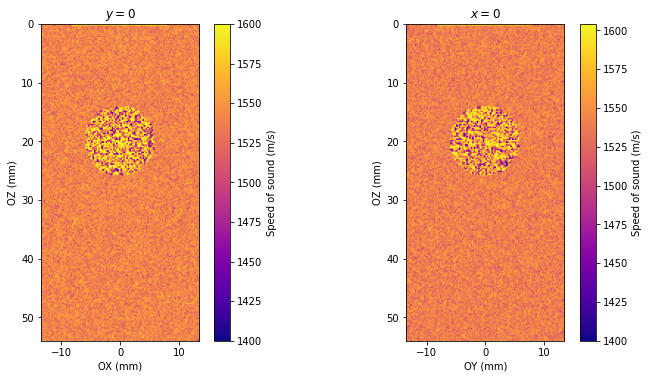

In [6]:
view_medium_and_probe_2d(medium, device, probe_c=1600, figsize=(10, 5))
plt.show()

If you want to see the presentation in 3D, uncomment the cell below.

In [7]:
# Uncomment the below lines to get the 3D visualization.
# camera_state = {"position": [30.649595627318874, 559.0460803905869, -16.879074818048537], "focalPoint": [107.5, 107.5, 215.5], "viewUp": [0.057747151432525394, -0.44903855002421966, -0.8916443501158829], "viewAngle": 30, "parallelScale": 131.4562664919402, "clippingRange": [395.47055895500773, 634.5553852882013], "windowCenter": [0, 0], "screenBottomLeft": [-0.5, -0.5, -0.5], "screenBottomRight": [0.5, -0.5, -0.5], "screenTopRight": [0.5, 0.5, -0.5], "physicalTranslation": [-107.5, -107.5, -215.5], "physicalScale": 131.4562664919402, "physicalViewUp": [0, 1, 0], "physicalViewNorth": [0, 0, -1], "mtime": 53436, "distance": 513.6145264511501}
# view_medium_and_probe_3d(medium, device, probe_c=1600, edge_gradient=0.8, camera=camera_state)

#### TX/RX Sequence

In [8]:
tx_rx_sequence = f["tx_rx_sequence"]
pretty_print_h5_group(tx_rx_sequence)

angles: (34,), float64
init_delay: (1, 1), float32
transmit_frequency: 3000000.0000


The `tx_rx_sequence` group describes the TX/RX sequence that was used to transmit and receive sequence that was during data acquisiion. The following fields are available:
- `angles`: a list of transmit angles $(rad)$,
- `init_delay`: moment of transmission in the center of the aperture (`time=0` is assigned to the first acquired sample) $(s)$,
- `transmit_frequency`: center frequency of the transmitted beam $(Hz)$.

Note: the transmit delays were chosen such that for all angles the aperture center was transmitting always at the same time. In particular: for angle $0$, all transmit delays were set to the `init_delay` value; for angles other than $0$, the elements at the center aperture (e.g. elements 31 and 32 for 64-element aperture) were transmitting at `~ init_delay`. As we will see later, this approach will simplify implementation of the receive beamformer.

#### Raw channel data

Finally, the dataset contains the raw channel data that we will use as input in our reconstruction algorithm. In particular:
- `rf_xy` contains raw channel data from: TX along OX axis, RX along OY axis,
- `rf_yx` contains raw channel data from: TX along OY axis, RX along OX axis.

In [9]:
n_angles, n_rx_elements, n_samples = f["rf_xy"][:].shape

In [10]:
n_angles

17

In [11]:
n_rx_elements

64

In [12]:
n_samples

1284

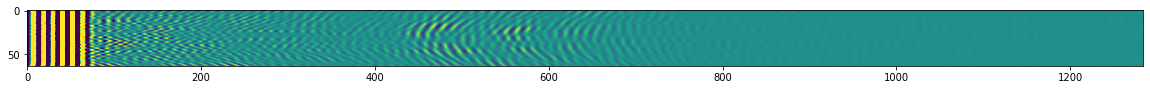

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(f["rf_xy"][0], vmin=-1000, vmax=1000)
plt.show()

### Beamformer: Lookup Table (LUT) approach

In this section we will implement a receive beamformer using classical delay and sum approach with a Lookup Table (LUT). 

The vanilla delay and sum algorithm is quite simple to describe: for each transmit (TX) angle $\varphi_j$, receive (RX) aperture element $r_i$, and a selected point $p$ of the insonified area, we determine the time of flight from TX to RX $t_{j, i}$ and we sum up all the samples acquired by each $r_i$ at time $t_{j, i}$. Here we extend that algorithm by RX apodization and *TX apodization* parameters in order to minimize the impact of the input signal from elements, which (to the best of our knowledge) most likely do not contain relevant information from the point $p$.  

Here we are focusing on the implementation of the Lookup Table (LUT) approach:
1. first, we pre-compute TX/RX delays and apodization arrays,
2. which we then use at the reconstruction stage.

This approach requires continuous reading of data from global memory, which can cost many GPU clock cycles, but on the other hand is much simpler to describe and learn. This is a good approach for the prototype implementation a beamformer on CUDA.

####  Implementation details

Let's start with the implementation of a function that prepares TX/RX delays and apodization weights.

In [14]:
def prepare_beamformer(output_grid, device, medium, tx_rx_sequence):
    # Initial assignments.
    x_grid, y_grid, z_grid = output_grid
    n_elements = device["n_elements_xy"][0] 
    # Note: we are assumming a probe with square (n+n) aperture.
    assert n_elements == device["n_elements_yx"][0]
    pitch = device["pitch"][0]
    angles = tx_rx_sequence["angles"][:]
    c = medium["speed_of_sound"][0]
    
    # Compute position of the each probe element. Note: the (0, 0, 0) is located in the center of probe.
    ri = cp.arange(n_elements)-n_elements//2+0.5
    ri = ri*pitch
    
    # Restructure all arrays that we will use later. 
    x = cp.asarray(x_grid).reshape(1, -1, 1)      # (1,   nx, 1)
    y = cp.asarray(y_grid).reshape(1, -1, 1)      # (1,   ny, 1)
    z = cp.asarray(z_grid).reshape(1, 1, -1)      # (1,   1,  nz)
    gamma = cp.asarray(angles).reshape(-1, 1, 1)  # (ntx, 1,  1)
    ri = cp.asarray(ri).reshape(-1, 1, 1)         # (nrx, 1,  1)

    # Compute TX delays.
    tx_distance = z*np.cos(gamma) + x*cp.sin(gamma)  # [m]
    tx_delays = tx_distance/c  # [s]

    # Compute RX delays.
    rx_distance = cp.sqrt(z**2 + (y-ri)**2)
    rx_delays = rx_distance/c
    
    # Compute "TX apodization".
    d1 = -n_elements/2 * pitch
    d2 = n_elements/2 * pitch
    tx_apodization_left = z*cp.sin(gamma) + (d1-x)*cp.cos(gamma) <= 0
    tx_apodization_right = z*cp.sin(gamma) + (d2-x)*cp.cos(gamma) >= 0
    tx_apodization = np.logical_and(tx_apodization_left, tx_apodization_right)
    tx_apodization = tx_apodization.astype(np.uint8)

    # Compute RX apodization.
    max_rx_tang = 0.5  # Determined experimentally. 
    rx_sigma = 1/2
    rx_tang = cp.abs((ri-y)/z)
    rx_apodization = cp.exp(-(rx_tang/max_rx_tang)**2 / (2*rx_sigma))
    rx_apodization[rx_tang > max_rx_tang] = 0.0

    return {
        "tx_delays": tx_delays,
        "rx_delays": rx_delays,
        "tx_apodization": tx_apodization,
        "rx_apodization": rx_apodization,
    }

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(0, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(output_grid, device, medium, tx_rx_sequence)

Details:

**TX delays**

Transmit delays are computed according to the previously defined formulas, please check the beginning of this notebook. As you may note, transmit delays depends only on `tx`, `z` and `x`. 

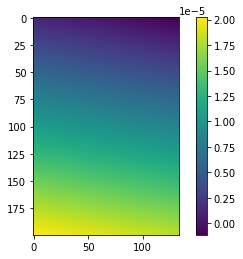

In [15]:
plt.imshow(beamformer_cfg["tx_delays"][0].get().T)
plt.colorbar()

**RX delays**

Recieve delays are computed according to the previously defined formulas, please check the beginning of this notebook. As you may note, receive delays depends only on `ri`, `z` and `y`. 


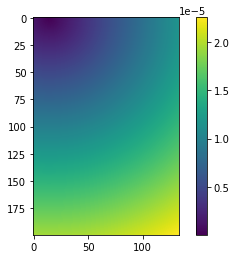

In [16]:
plt.imshow(beamformer_cfg["rx_delays"][0].get().T)
plt.colorbar()

**TX apodization**

The purpose of the *TX apodization* is to limit the imaging area to the points where the ultrasound signal actually reached. In the case of plane wave transmission, we would like to check if the selected point $p = (y, x, z)$ is to the left of the dotted line indicated by the $\varphi$ arrow (or symmetrically on the right side of the aperture) -- this is area where the ultrasound beam (the orange dotted line) is not reaching:

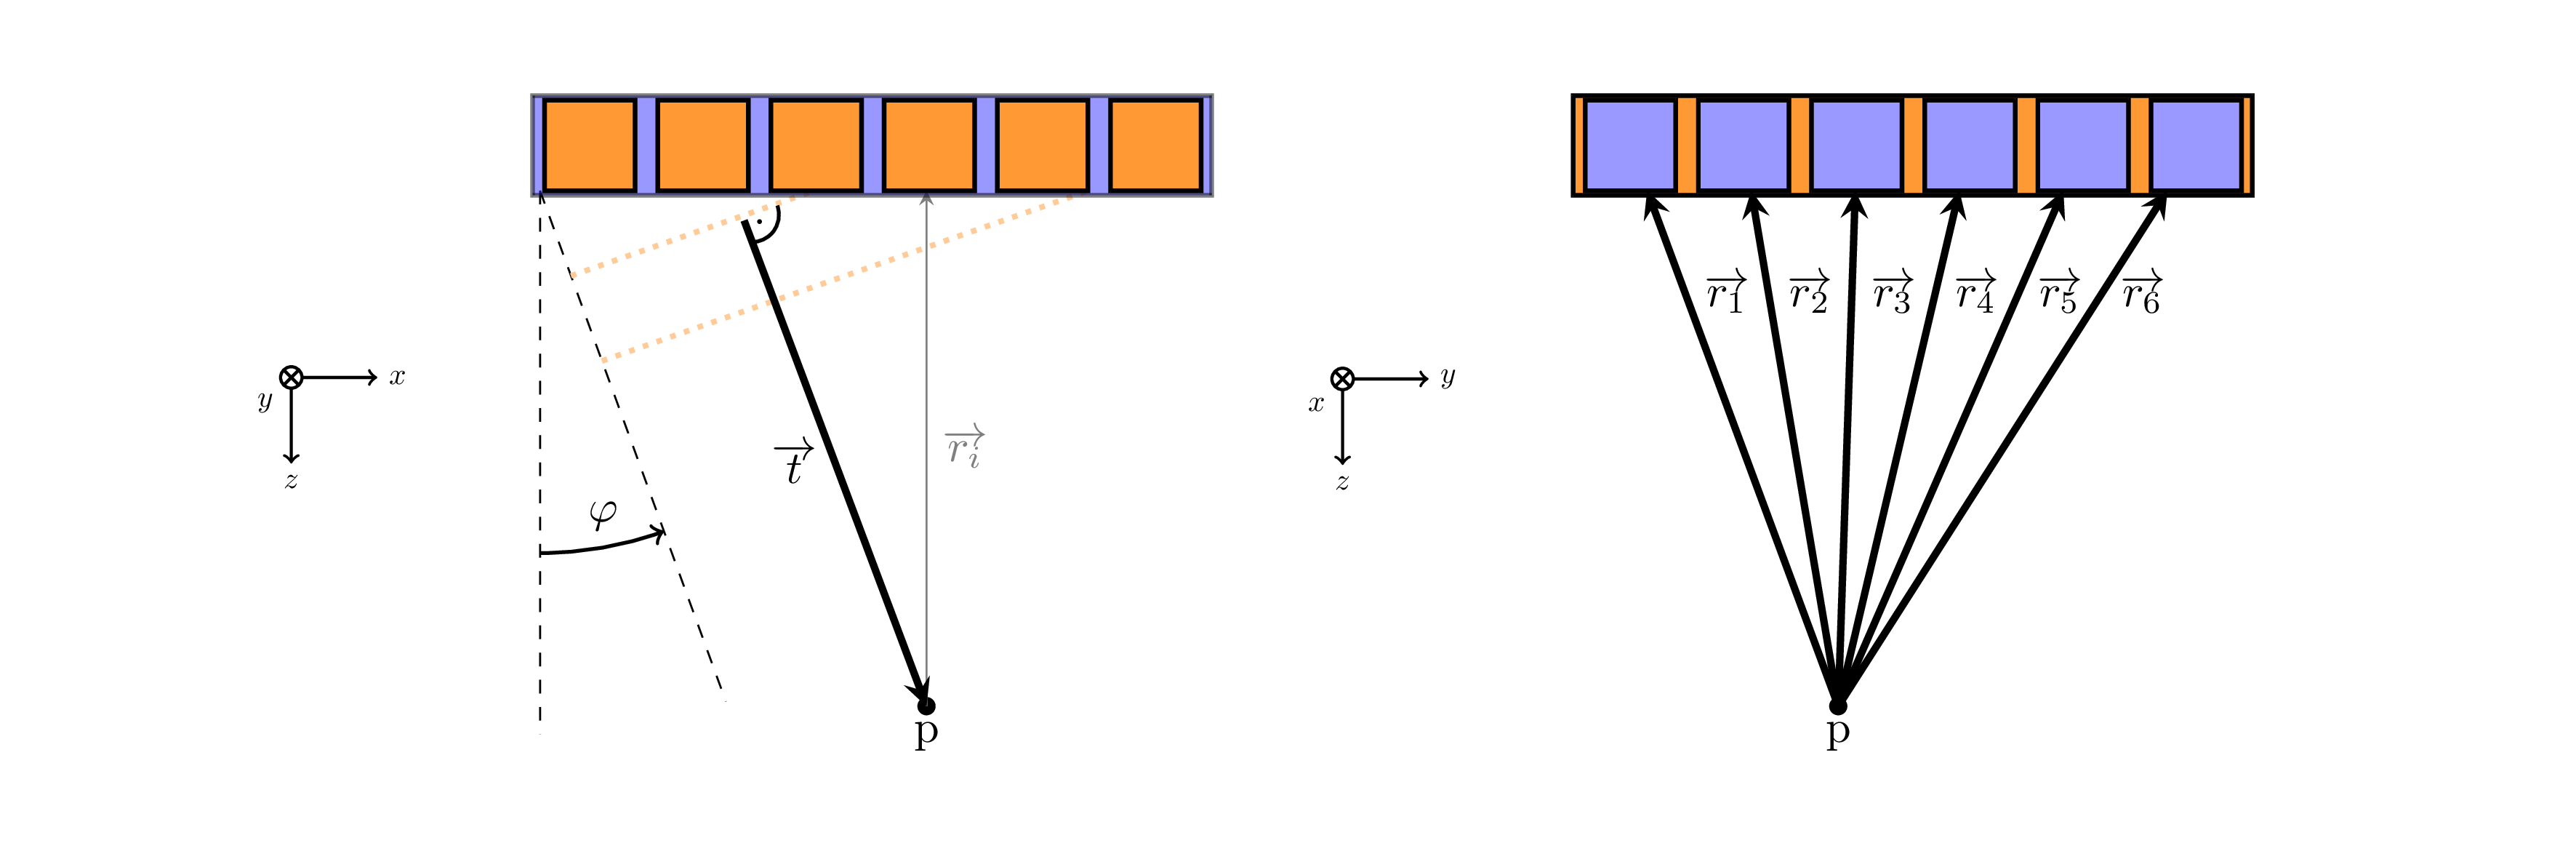


To do that, we perform the following transformations:
1. move the origin of the coordinate system to the left end of the transmit aperture,
2. rotate vector $(x, z)$ by $\pi/2$, to $(-z, x)$,
3. compute dot product between $(-z, x)$ and a unit vector in the direction of $varphi$ angle,
4. if the dot product is less than $0$, the point $(z, x)$ is in the insonified area.

(we can do analogous calculations for the right end of the aperture)

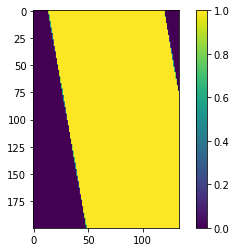

In [17]:
plt.imshow(beamformer_cfg["tx_apodization"][-1].get().T)
plt.colorbar()

**RX apodization**

In the case of RX apodization:
- the signal from the selected probe element will be only included in calculations points $p$ located in the field of view $(-\arctan(0.5), \arctan(0.5))$ (value $0.5$ was determined experimentally),
- we apply a Gaussian window on the signal from the aperture elements.

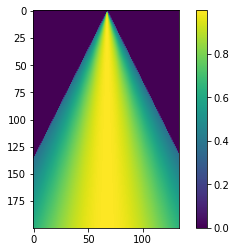

In [18]:
plt.imshow(beamformer_cfg["rx_apodization"][32].get().T)
plt.colorbar()

Now, let's move on to the implementation of GPU kernel, which we will use to reconstruct B-mode volume from raw channel data using the pre-computed TX/RX delays and apodization weights. The implementation of beamformer is available in the `1_delayAndSumLUT.cc` file, the below function compiles it, prepares input data, computes block and grid sizes and calls the kernel.

In [19]:
def delay_and_sum_lut(input_array,
                      output_grid,
                      medium, device, tx_rx_sequence,
                      tx_apodization, rx_apodization,
                      tx_delays, rx_delays):
    # Initialization
    # Compile beamformer source code.
    kernel_source = pathlib.Path("1_delayAndSumLUT.cc").read_text()
    kernel_module = cp.RawModule(code=kernel_source)
    kernel_module.compile()
    kernel = kernel_module.get_function("delayAndSumLUT")
    n_tx, n_rx, n_samples = input_array.shape
    x_grid, y_grid, z_grid = output_grid
    output_array = cp.zeros((n_tx, len(y_grid), len(x_grid), len(z_grid)),
                            dtype=cp.float32)
    
    init_delay = tx_rx_sequence["init_delay"][0].item()
    fc = tx_rx_sequence["transmit_frequency"][0].item()
    fs = device["sampling_frequency"][0].item()
    
    input_array = cp.asarray(input_array).astype(cp.float32)
    n_tx, n_y_pix, n_x_pix, n_z_pix = output_array.shape
    params = (
        output_array,
        input_array,
        tx_apodization.astype(cp.uint8),
        rx_apodization.astype(cp.float32),
        tx_delays.astype(cp.float32),
        rx_delays.astype(cp.float32),
        np.float32(init_delay),
        n_tx, n_samples, n_rx,
        n_x_pix, n_y_pix, n_z_pix,
        np.float32(fs), np.float32(fc)
    )
    x_block_size = min(n_x_pix, 8)
    y_block_size = min(n_y_pix, 8)
    z_block_size = min(n_z_pix, 8)
    block_size = (
        z_block_size,
        x_block_size,
        y_block_size
    )
    grid_size = (
        (n_z_pix-1)//z_block_size+1,
        (n_x_pix-1)//x_block_size+1,
        (n_y_pix-1)//y_block_size+1
    )
    kernel(
        grid_size,
        block_size,
        params
    )
    return output_array.get()

We will use the following function to convert the beamformed data to B-mode images.

In [20]:
def postprocess(data_xz, data_yz, tx_rx_sequence, output_grid, tgc_alpha_coeff=0, tgc_alpha_power=1, dynamic_range=(-20, 0)):
    data_yz = data_yz.transpose((0, 2, 1, 3))
    # Compound.
    hri = (np.mean(data_xz, axis=0)+np.mean(data_yz, axis=0))/2
    # TCG
    if tgc_alpha_coeff != 0:
        _, _, z_grid = output_grid
        z_grid = z_grid.get()
        print(z_grid.shape)
        fc = tx_rx_sequence["transmit_frequency"][0]
        gain = tgc_alpha_coeff*fc*1e-6*tgc_alpha_power
        gain = gain/8.686*1e2
        curve = np.exp(gain*2*z_grid).reshape(1, 1, -1)
        hri = hri*curve
    # Envelope.
    envelope = np.abs(scipy.signal.hilbert(hri))
    envelope_max = np.max(envelope)
    # B-mode.
    bmode = 20*np.log10(envelope/envelope_max)
    # Adjust dynamic range.
    vmin, vmax = dynamic_range
    bmode = np.clip(bmode, a_min=vmin, a_max=vmax)
    bmode = np.transpose(bmode, (2, 0, 1))
    return bmode

#### Testing

In this section, we test the implementation of the reconstruction algorithm on the available datasets. 

Note: data sets include raw channel data for the following two setups:
1. transmit with elements along OX, receive with elements OY,
2. transmit with elements along OY, receive with elements OX.

Taking advantage of the fact that the 2nd. case is symmetric to the 1st, for both setups we use the same beamformer implementation, and simply transpose the output for the 2nd (please check the implementation of `postprocess` function). This way we avoid duplicating of the beamformer kernel code.  

**Single point**

In [21]:
f = h5py.File("data/ball.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
y_grid = cp.arange(-4, 4, 0.1)*1e-3  # [m]
z_grid = cp.arange(16, 24, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

single_point_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

single_point_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

single_point = postprocess(
    single_point_xy, single_point_yx,
    tx_rx_sequence=tx_rx_sequence,
    output_grid=output_grid,
    dynamic_range=(-20, 0))

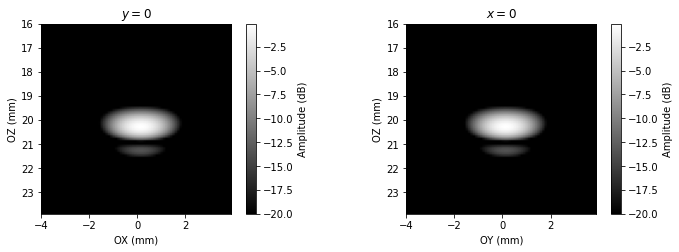

In [22]:
view_volume_2d(single_point, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 3))

In [23]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-10.505655646769233, -25.96663433912618, -145.55767768525075], "focalPoint": [79.5, 79.5, 79.5], "viewUp": [-0.9296744298109059, 0.007449413877255744, 0.36830688398216604], "viewAngle": 30, "parallelScale": 68.41600689897065, "clippingRange": [193.20073194266212, 337.14930875040375], "windowCenter": [0, 0], "screenBottomLeft": [-0.5, -0.5, -0.5], "screenBottomRight": [0.5, -0.5, -0.5], "screenTopRight": [0.5, 0.5, -0.5], "physicalTranslation": [-79.5, -79.5, -79.5], "physicalScale": 68.41600689897065, "physicalViewUp": [0, 1, 0], "physicalViewNorth": [0, 0, -1], "mtime": 66608, "distance": 264.33915198114886}
# view_volume_3d(single_point, colormap="Cool to Warm", camera=camera_state)

**Wire phantom**

In [24]:
f = h5py.File("data/multi_wire.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.1)*1e-3  # [m]
z_grid = cp.arange(5, 50, 0.1)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

wires_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

wires_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

wires = postprocess(
    wires_xy, wires_yx, 
    tx_rx_sequence=tx_rx_sequence, 
    output_grid=output_grid, 
    tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
    dynamic_range=(-10, 0))

(450,)


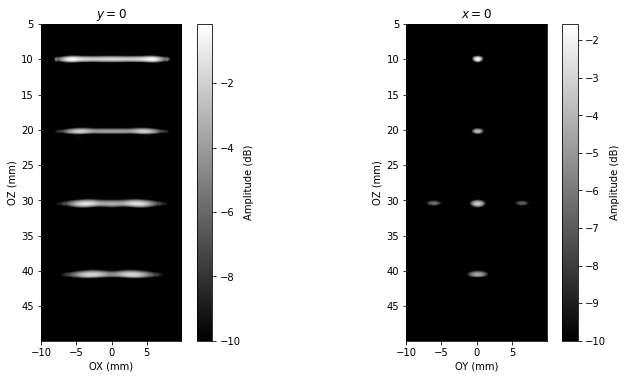

In [25]:
view_volume_2d(wires, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 5))

In [26]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-13.625584081936577, -890.0895638036304, 367.908122256037], "focalPoint": [362.5, 161, 161], "viewUp": [-0.9429152274692622, 0.31784252364289906, -0.09943341476034367], "viewAngle": 30}
# view_volume_3d(wires, edge_gradient=0.4, colormap="Cool to Warm", camera=camera_state)

**Cyst**

In [27]:
f = h5py.File("data/cyst.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(10, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)

cyst_xy = delay_and_sum_lut(
    input_array=f["rf_xy"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

cyst_yx = delay_and_sum_lut(
    input_array=f["rf_yx"][:], 
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence,
    **beamformer_cfg)

cyst = postprocess(
    cyst_xy, cyst_yx, 
    tx_rx_sequence=tx_rx_sequence, 
    output_grid=output_grid,
    tgc_alpha_coeff=0.7, tgc_alpha_power=1.5, 
    dynamic_range=(-17, 0))

(134,)


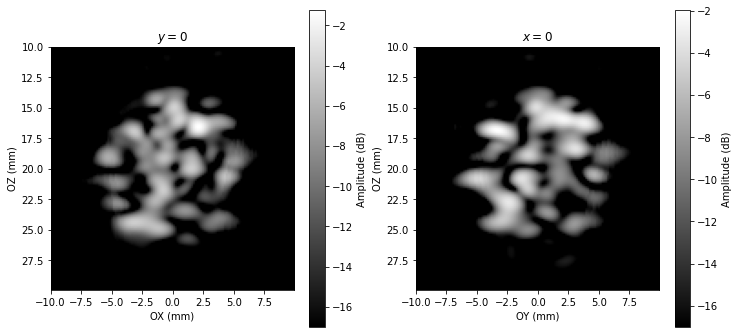

In [28]:
view_volume_2d(cyst, x_grid.get(), y_grid.get(), z_grid.get(), figsize=(10, 5))

In [29]:
# Uncomment the below lines to see the 3D visualization.
# camera_state = {"position": [-195.56552833013455,-211.72156083213406,-360.49602691514167],"focalPoint": [255,169.5,169.5],"viewUp": [-0.810542332416492,0.46749694290132965,0.35279985223741744], "viewAngle": 30}
# view_volume_3d(cyst, edge_gradient=0.4, camera=camera_state)

#### Profiling

In [30]:
%%writefile 1_delay_and_sum_lut.py

import h5py
import cupy as cp
from rca_reconstruction import (
    prepare_beamformer, 
    delay_and_sum_lut
)

f = h5py.File("data/cyst.h5", "r")

medium = f["medium"]
device = f["device"]
tx_rx_sequence = f["tx_rx_sequence"]

x_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
y_grid = cp.arange(-10, 10, 0.15)*1e-3  # [m]
z_grid = cp.arange(10, 30, 0.15)*1e-3  # [m]

output_grid = (
    x_grid, y_grid, z_grid
)

beamformer_cfg = prepare_beamformer(
    output_grid=output_grid,
    medium=medium,
    device=device,
    tx_rx_sequence=tx_rx_sequence
)
for i in range(10):
    cyst_xy = delay_and_sum_lut(
        input_array=f["rf_xy"][:], 
        output_grid=output_grid, 
        medium=medium,
        device=device,
        tx_rx_sequence=tx_rx_sequence,
        **beamformer_cfg)

Overwriting 1_delay_and_sum_lut.py


In [31]:
! nvprof --trace gpu python 1_delay_and_sum_lut.py

==1060386== NVPROF is profiling process 1060386, command: python 1_delay_and_sum_lut.py
==1060386== Profiling application: python 1_delay_and_sum_lut.py
==1060386== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   56.64%  469.20ms        10  46.920ms  46.764ms  47.230ms  delayAndSumLUT
                   42.29%  350.30ms        11  31.846ms  2.0800us  35.484ms  [CUDA memcpy DtoH]
                    0.55%  4.5154ms        11  410.49us  1.3120us  451.56us  [CUDA memcpy HtoD]
                    0.17%  1.4360ms        30  47.866us  30.561us  57.218us  cupy_copy__float64_float32
                    0.11%  926.14us         3  308.71us  5.8240us  910.81us  cupy_power__float64_float_float64
                    0.05%  447.76us        10  44.775us  44.161us  45.217us  cupy_copy__float32_float32
                    0.03%  271.82us         4  67.954us  42.305us  76.675us  cupy_true_divide__float64_float_float64
               

## References

[Jensen2022] Jensen, Jørgen Arendt, et al. , Anatomic and Functional Imaging using Row-Column Arrays. IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control (2022) https://doi.org/10.1109/TUFFC.2022.3191391

[Flesch2017] Flesch, M., et al. "4D in vivo ultrafast ultrasound imaging using a row-column addressed matrix and coherently-compounded orthogonal plane waves." Physics in Medicine & Biology 62.11 (2017): 4571. https://iopscience.iop.org/article/10.1088/1361-6560/aa63d9/meta